<a href="https://colab.research.google.com/github/myielin/EEG_analysis_toolkit/blob/main/frequency_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EEG Signal Prediction

Procedure overview: the preprocessed EEG data is normalized and subdivided into sections of half a second of duration in a 'sliding window' fashion. Each window is provided as input to train a neural network, which learns how to forecast the values of the next window.

### 1.
installs and imports

In [ ]:
!pip install mne
!pip install keras_tuner

In [2]:
import mne
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten, Conv1D, Dropout, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import keras_tuner

### 2.
Function definitions

The first two functions normalize the data in relation to the current time section and "unnormalizes" it if necessary. This is very important for model training because it increases the scale of signal values, which originaly vary in the order of microvolts (10⁻⁶)

In [5]:
def norm(x):
    normX = (x-np.mean(x)) / np.std(x)
    return normX

def unnorm(x):
    normX = x * np.std(x) + np.mean(x)
    return normX


The split_seq function creates the sliding windows from the whole EEG signal. Setting it to half a second of duration means that each window correspond to a set of values captured during any given interval of 500ms.

Parameters are:
- the sequence of signals (the whole EEG data);
- channels of interest;
- the number of signals contained in each window (in this case, half a second corresponds to 100 values because the sampling frequency of the data is 200 Hz);
- the stride between windows - how many values are skipped from one window to the next;
- whether normalization is performed or not

In [6]:
def split_seq(seq, ch, n, step, normalize=False):
    data = seq.get_data(picks=ch)

    if normalize: data = norm(data)

    sigs = sliding_window_view(data, window_shape=n, axis=1).transpose(1, 0, 2)
    sigs = sigs[::step]

    freqs = np.empty(sigs.shape[0])
    for i in range(sigs.shape[0]):
      mne_i = mne.io.RawArray(sigs[i], info=seq.copy().pick(ch).info, verbose = False)
      psd = mne_i.compute_psd(fmax=100, fmin=5, verbose = False)
      freqs[i] = psd.freqs[np.argmax(psd.get_data()[-1])]


    return sigs, freqs

The EarlyStop class defines two callbacks: a gradual reduction of the learning rate on each batch end and a signal to halt model training once it reaches a specific loss value. This step is completely optional.

In [7]:
class earlyStop(Callback):
    def on_train_batch_end(self, batch, logs={}):
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate* 0.99)
        if logs.get('loss') <= 0.00001:   # tweak this value according to the training context
            print(f"\n\n Loss = {logs.get('loss')}, stopping training\n\n")
            self.model.stop_training = True


    def on_epoch_end(self, epoch, logs):
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate* 0.95)
        print("\nLR: ", float(self.model.optimizer.learning_rate))

The implemented model is a simple CNN-LSTM architecture. It does not require too many computational resources and suits many EEG analysis contexts.

The number of filters in the CNN layer is optimized via Keras Tuner

In [142]:
def build_model(p1):
  lstm = Sequential()

  lstm.add(Input( (l,n)))
  lstm.add(Conv1D(filters=p1.Choice('units', [10, n//2, n, 2*n]),  kernel_size=(l)))
  lstm.add(LSTM(units=(p1.Choice('units3', [n, 2*n, 5*n]) ), return_sequences=True))
  lstm.add(Dropout(rate=p1.Choice("drop", [0.2,0.3, 0.4, 0.45])))
  lstm.add(LSTM(units=(p1.Choice('units3', [n, 2*n, 5*n]) ), return_sequences=False))
  lstm.add(Dense(outShape, activation="softmax"))

  lstm.compile(loss='categorical_crossentropy', metrics=['mean_absolute_error', 'accuracy'], optimizer='adam')

  return lstm

Finally, the last function organizes the test data for model evaluation and visualization of performance

In [127]:
def test_model(x, y, idx):
  preds, reals = [], []
  for i in range(idx, idx+10):
    pval = lstm.predict(x[i].reshape(1,l, n))
    preds.append(int(vals[np.argmax(pval)]))
    reals.append(int(vals[np.argmax(y[i])]))


  print(f"Some predicted values starting at index {idx}::\n{preds}")
  print(f"Real values starting at index {idx}          ::\n{reals}")

  return preds, reals


### 3.
Execute the appropriate functions

In this case, the model is trained on the sample2 EEG file and tested in the sample1. Both EEG sets are already preprocessed from the preprocessing script.

In [84]:
p = 'data/'
data = mne.io.read_raw_fif("train1.fif")

Opening raw data file train1.fif...
    Range : 0 ... 75525 =      0.000 ...   377.625 secs
Ready.


['P4', 'P3', 'Fp2', 'Fp1']
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


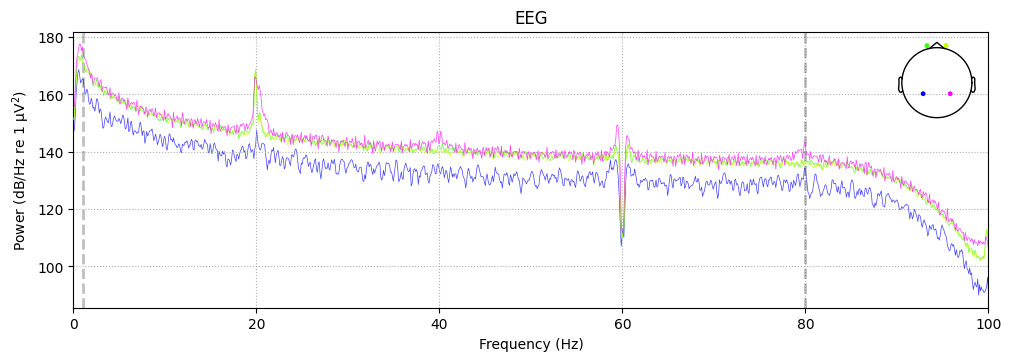

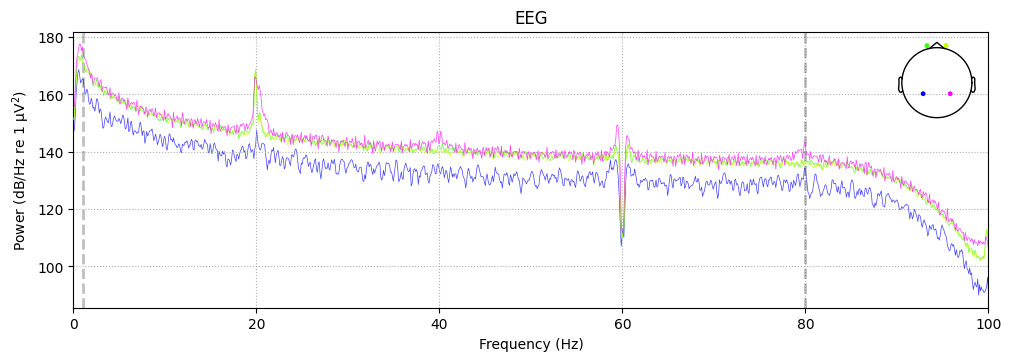

In [11]:
print(data.ch_names)
data.plot_psd()

The next section is where parameters are defined to create the sliding windows. In this example, the two frontal channels are selected (yellow and green lines in the graph above)

In [85]:
# defining input and output length for the model
n = 100                 # half a second of duration
stride = n//2           # stride for the sliding window

chn = ["Fp1", "Fp2"]
l = len(chn)            # an important value that will be used for dimentioning later

x, y = split_seq(data, chn, n, stride, normalize=False)       # train

In [126]:
# the last window is not included in the 'x' (training input) set,
# while the 'y' set (what is predicted) does not include the first window
# in this context it is also necessary to one-hot encode the y variable

y = y[1:]
o = ohe( sparse_output=False)
y_ohe = o.fit_transform(y.reshape(-1,1))
vals = np.unique(y)
outShape = len(vals)

x = x[:-1]

In [88]:
# dimentionality of x and y sets
print(x.shape, y_ohe.shape)

(1507, 2, 100) (1507, 17)


The testing set is a subdivision of 20% of the whole dataset. The remaining 80% is for training

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x, y_ohe, test_size=0.2)

Once the data is ready, the model is trained and optimized. This trained model may be saved for later use

In [143]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)

tuner = keras_tuner.RandomSearch(build_model, objective='val_accuracy')
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[reduce_lr])
lstm = tuner.get_best_models()[0]

Trial 10 Complete [00h 02m 23s]
val_accuracy: 0.6026490330696106

Best val_accuracy So Far: 0.6026490330696106
Total elapsed time: 00h 12m 01s


In [17]:
lstm.save('frq-model.keras')

### 4.
Model testing. The last function

In [147]:
pred, real = test_model(x_test,y_test, 134)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Some predicted values starting at index 134::
[6, 20, 20, 6, 20, 6, 20, 6, 6, 6]
Real values starting at index 134          ::
[6, 20, 20, 6, 6, 60, 8, 6, 6, 6]
